In [51]:
# a mondat, amire meg szeretném kapni a predikciót
input_sent = 'fun today with my friends, I enjoy being with them and celebrating life'

In [32]:
import pandas as pd
import bisect
import re
import nltk
import numpy as np
import string
import spacy
import requests
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from PIL import Image

In [50]:
train_dataset = pd.read_csv('sentences_with_stopwords.csv')

In [34]:
# language modell:
nlp = spacy.load("en_core_web_md")

# ezek az oszlopnevekhez kellenek:
list_of_feature_cols_str = [str(i) for i in range(0, 300)]
list_of_feature_cols = [i for i in range(0, 300)]

In [35]:
# ez az összes mondathoz tartozó embedded vektor a tanuló adatbázisból, lista formátumban
train_embed_vector = [
    list(train_dataset[list_of_feature_cols_str].iloc[i, :])
    for i in range(len(train_dataset))
]

In [37]:
# a szöveg feldolgozása:
text = str(input_sent)
doc = nlp(text)
vector_for_pred = doc.vector
entity = list(doc.ents)
descriptions_dict = {text: vector_for_pred}
documents_df_for_pred = pd.DataFrame.from_dict(descriptions_dict, orient="index")
# ez lesz majd az input a kis fának:
inputtext_df_data = documents_df_for_pred[list_of_feature_cols]
testData = inputtext_df_data
testData.columns = testData.columns.map(str)  
# ez is lista formában a vektorok
input_embed_vector = list(testData[list_of_feature_cols_str].iloc[0,:])

## ez pedig nearest neighbours klaszterezéssel:

In [38]:
train_embed_array = [np.array(element) for element in train_embed_vector]
input_embed_array = [np.array(input_embed_vector)]
both_vector_lists = np.concatenate( (train_embed_array, input_embed_array ) )
model = NearestNeighbors(n_neighbors=2, metric="cosine", algorithm="brute", n_jobs=-1)
nbrs = model.fit(both_vector_lists)
distances, indices = nbrs.kneighbors(both_vector_lists)
# minimum index keresése
min_dist_ind = [element[1] for element in indices]

In [39]:
predicted_card_nneighbors = train_dataset['card'][min_dist_ind[-1]]

Legközelebbi kártya nneighbors szerint: Queen of Cups


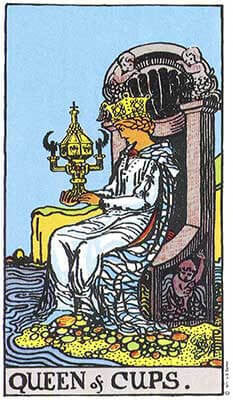

In [41]:
URL = 'https://'+ train_dataset[train_dataset['card']==predicted_card_nneighbors]['img_url'].iloc[0][2:]
im = Image.open(requests.get(URL, stream=True).raw)
print("Legközelebbi kártya nneighbors szerint: " + predicted_card_nneighbors)
im

# megnézem, összességében mennyire sikeres a cos távolság

In [22]:
# ezzel csak megfelelő formátumba hozom a vektorok listáját
train_embed_vector = [
    list(train_dataset[list_of_feature_cols_str].iloc[i, :])
    for i in range(len(train_dataset))
]
# nearest neighbors model
model = NearestNeighbors(n_neighbors=2, metric="cosine", algorithm="brute", n_jobs=-1)
nbrs = model.fit(train_embed_vector)
distances, indices = nbrs.kneighbors(train_embed_vector)
# minimum index keresése
min_dist_ind = [element[1] for element in indices]
# melyik szövegre melyik kártyát tippelte?
predicted_cards = [
    train_dataset["card"][min_dist_ind[i]] for i in range(len(train_dataset))
]
train_dataset["cos_prediction"] = predicted_cards
# mi volt így a sikerráta
success_rate = str(
    round(
        (
            (
                len(
                    train_dataset[
                        train_dataset["card"] == train_dataset["cos_prediction"]
                    ]
                )
                / len(train_dataset)
            )
            * 100
        ),
        2,
    )
)
print(
    "Success rate of cosine distance with nearest neighbours is: " + success_rate + "%"
)

Success rate of cosine distance with nearest neighbours is: 6.05%


# megnézem, összességében mennyire sikeres a döntési fa

In [43]:
df = None
def train_test_split_func(y_colname="card", df=df):
    retlist = train_test_split(
        df.drop(y_colname, axis=1).values,
        df[y_colname].values,
        stratify = df[y_colname].values,
        test_size=600,
        random_state=0,
    )

    return [
        pd.DataFrame(f, columns=[f for f in df.columns if not f == y_colname])
        if i < 2
        else pd.DataFrame(f, columns=[y_colname])
        for i, f in enumerate(retlist)
    ]

X_train, X_test, y_train, y_test = train_test_split_func(y_colname="card", df=train_dataset)
params = {"max_depth": 50}
dec_tree = DecisionTreeClassifier(**params).fit(X_train.loc[:, list_of_feature_cols_str], y_train)
test_preds = dec_tree.predict(X_test.loc[:, list_of_feature_cols_str])
compare = pd.DataFrame()
compare["orig"]  = y_test
compare["preds"] = test_preds
compare["text"] = X_test['text2']
print(
    "Success rate of decision tree is: "
    + str(
        round(len(compare[compare["orig"] == compare["preds"]]) / len(compare) * 100, 2)
    )
    + "%"
)

Success rate of decision tree is: 2.67%


In [44]:
test_preds_tree = dec_tree.predict(testData.loc[:, list_of_feature_cols_str])

In [47]:
predicted_card_dectree = test_preds_tree[0]

Legközelebbi kártya nneighbors szerint: Page of Swords


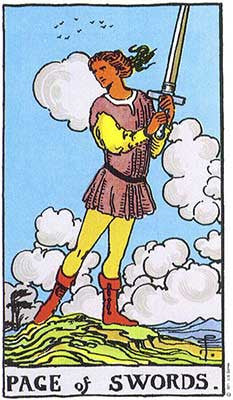

In [48]:
URL = 'https://'+ train_dataset[train_dataset['card']==predicted_card_dectree]['img_url'].iloc[0][2:]
im = Image.open(requests.get(URL, stream=True).raw)
print("Legközelebbi kártya nneighbors szerint: " + predicted_card_dectree)
im